### Modelo SARIMA para predição de temperaturas de SST - Sea Surface Temperature Forecasting

In [255]:
import numpy as np
import netCDF4 as nc
import xarray as xr
import numpy as np
import netCDF4 as nc
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
import matplotlib.pyplot as plt
import pandas as pd
from dtw import *
from tqdm import tqdm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from common.utils import mape
import warnings
import math
warnings.filterwarnings("ignore") # specify to ignore warning messages

### Carrengando o dataset e tratando os dados e colunas não úteis

In [256]:
fp = '../data/sst.mnmean.nc'
ds = nc.Dataset(fp)

In [257]:
ds = xr.open_dataset(fp)
df = ds.to_dataframe()

In [258]:
df = df.reset_index()
df = df[df['nbnds'] == 0] # Garante que há apenas uma medição por área por tempo
df = df.drop('nbnds', axis='columns')
df = df.drop('time_bnds', axis='columns')

In [262]:
print("Latitudes", df['lat'].unique())
print("Longitudes", df['lon'].unique())

Latitudes [ 88.  86.  84.  82.  80.  78.  76.  74.  72.  70.  68.  66.  64.  62.
  60.  58.  56.  54.  52.  50.  48.  46.  44.  42.  40.  38.  36.  34.
  32.  30.  28.  26.  24.  22.  20.  18.  16.  14.  12.  10.   8.   6.
   4.   2.   0.  -2.  -4.  -6.  -8. -10. -12. -14. -16. -18. -20. -22.
 -24. -26. -28. -30. -32. -34. -36. -38. -40. -42. -44. -46. -48. -50.
 -52. -54. -56. -58. -60. -62. -64. -66. -68. -70. -72. -74. -76. -78.
 -80. -82. -84. -86. -88.]
Longitudes [  0.   2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.
  28.  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.
  56.  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.
  84.  86.  88.  90.  92.  94.  96.  98. 100. 102. 104. 106. 108. 110.
 112. 114. 116. 118. 120. 122. 124. 126. 128. 130. 132. 134. 136. 138.
 140. 142. 144. 146. 148. 150. 152. 154. 156. 158. 160. 162. 164. 166.
 168. 170. 172. 174. 176. 178. 180. 182. 184. 186. 188. 190. 192. 194.
 196. 198. 200. 202. 204. 206

In [268]:
df.head()

,lat,lon,time,sst
0,88.0,0.0,1854-01-01,-1.8
2,88.0,0.0,1854-02-01,-1.8
4,88.0,0.0,1854-03-01,-1.8
6,88.0,0.0,1854-04-01,-1.8
8,88.0,0.0,1854-05-01,-1.8


### Funções úteis

In [269]:
# setando column_name como índice do dataframe
def set_dataframe_index(df: pd.DataFrame, column_name: str):
    return df.set_index(column_name)

def get_date_and_temperature_from(df: pd.DataFrame, lat: int, lon: int):
    return df[(df['lat'] == lat) & (df['lon'] == lon)]

f_inv = lambda x: x + 180
f = lambda x: ((x+180) % 360) - 180

In [270]:
#setando a culuna tempo como índice do dataframe
df = set_dataframe_index(df, 'time')
df.head()

,lat,lon,sst
time,,,
1854-01-01,88.0,0.0,-1.8
1854-02-01,88.0,0.0,-1.8
1854-03-01,88.0,0.0,-1.8
1854-04-01,88.0,0.0,-1.8
1854-05-01,88.0,0.0,-1.8


### Pegando a temperatura de um ponto no dataset

In [271]:
df_sst_lat_lon = get_date_and_temperature_from(df, 32.0, 16.0)

# os pontos definidos de latitude e longitude
# lat = 20°, lon = -132°
#df_sst_enso = get_date_and_temperature_from(df, f_inv(20.0), f_inv(-132.0))

# lat = -22°, lon = -72°
#df_sst_chile = get_date_and_temperature_from(df, f_inv(-22.0), f_inv(-72.0))

# lat = 36°, lon = 18°
#df_sst_medit = get_date_and_temperature_from(df, f_inv(36.0), f_inv(18.0))

# lat = 0°, lon = -22°
#df_sst_atlantico = get_date_and_temperature_from(df, f_inv(0.0), f_inv(-22.0))

# lat = -56°, lon = 80°
#df_sst_indico = get_date_and_temperature_from(df, f_inv(-56.0), f_inv(80.0))


In [272]:
df_sst_lat_lon.head()

,lat,lon,sst
time,,,
1854-01-01,32.0,16.0,17.333422
1854-02-01,32.0,16.0,16.721617
1854-03-01,32.0,16.0,16.491089
1854-04-01,32.0,16.0,17.444820
1854-05-01,32.0,16.0,19.150229


### Plotando a temperatura de um ponto do dataset atravéz do tempo

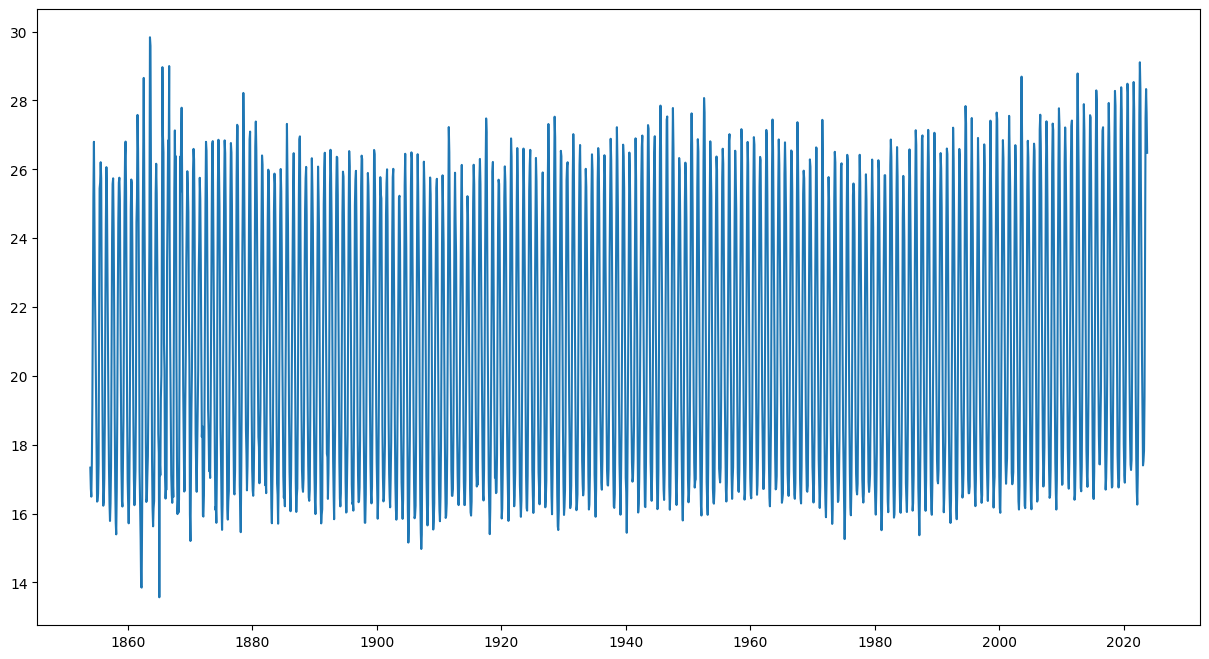

In [273]:
index = df_sst_lat_lon.index.tolist()
plt.figure(figsize=(15,8))
plt.plot(index,df_sst_lat_lon['sst'])
plt.show()

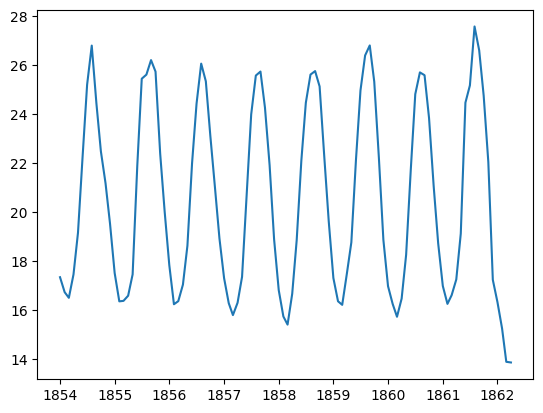

In [274]:
#plotando a temperatura do ponto atravéz do tempo para as primeiras 100 leituras
index = df_sst_lat_lon.index.tolist()
plt.plot(index[:100],df_sst_lat_lon['sst'][:100])
plt.show()

### Criando os datasets de treino e teste

In [276]:
# separa em treino e teste
X = df_sst_lat_lon['sst'].to_frame()
#X = df.columns.get_indexer(['sst'])
size = int(len(X) * 0.8)
train, test = X[0:size], X[size:len(X)]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

train.head()

Training data shape:  (1630, 1)
Test data shape:  (408, 1)


,sst
time,
1854-01-01,17.333422
1854-02-01,16.721617
1854-03-01,16.491089
1854-04-01,17.444820
1854-05-01,19.150229


In [277]:
# fazendo o pandas inferir a frequencia do índice #MS=month start frequency para esse dataset
train.index = pd.DatetimeIndex(train.index.values, freq=train.index.inferred_freq)
test.index = pd.DatetimeIndex(test.index.values, freq=test.index.inferred_freq)
train.index 

DatetimeIndex(['1854-01-01', '1854-02-01', '1854-03-01', '1854-04-01',
               '1854-05-01', '1854-06-01', '1854-07-01', '1854-08-01',
               '1854-09-01', '1854-10-01',
               ...
               '1989-01-01', '1989-02-01', '1989-03-01', '1989-04-01',
               '1989-05-01', '1989-06-01', '1989-07-01', '1989-08-01',
               '1989-09-01', '1989-10-01'],
              dtype='datetime64[ns]', length=1630, freq='MS')

### Implementando o ARIMA/SARIMA

An ARIMA, which stands for AutoRegressive Integrated Moving Average, model can be created using the statsmodels library. In the next section, we perform the following steps:

    Define the model by calling SARIMAX() and passing in the model parameters: p, d, and q parameters, and P, D, and Q parameters.
    The model is prepared on the training data by calling the fit() function.
    Predictions can be made by calling the forecast() function and specifying the number of steps (horizon) which to forecast

In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are:

    p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values.
    d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
    q is the parameter associated with the moving average part of the model.

If our model has a seasonal component, we use a seasonal ARIMA model (SARIMA). In that case we have another set of parameters: P, D, and Q which describe the same associations as p,d, and q, but correspond with the seasonal components of the model.


### Otimizando os parâmetros para o SARIMA

In [278]:
#https://alkaline-ml.com/pmdarima/0.9.0/setup.html#setup
#from pyramid.arima import auto_arima

In [279]:
# referênica 
# https://alkaline-ml.com/pmdarima/0.9.0/modules/generated/pyramid.arima.auto_arima.html

# Procura pelos melhores parâmetros (order e seasonal_order)
#Even after differencing the data by 24 hours (the seasonal frequency), we still see a seasonal trend in the data.
#Selecting the best parameters for an Arima model can be challenging - somewhat subjective and time intesive, 
#so we'll leave it as an exercise to the user. We used an auto_arima() function to search a provided space of 
#parameters for the best model.

''''''
auto_tune = False

if (auto_tune):
    auto_model = auto_arima(train, start_p=1, start_q=0,
                               max_p=5, max_q=0, m=24,
                               start_P=0, max_P=2,Q=0, 
                               seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    print(auto_model.aic())
    print(auto_model.summary())
''''''

''

### Treinando o modelo com o dataset de treino

Aqui depois de obter os parâmetros `order` e `seadonal_order` do otimizador **auto_arima** do bloco anterior

In [280]:
order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                sst   No. Observations:                 1630
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -1346.681
Date:                            Thu, 23 Nov 2023   AIC                           2703.362
Time:                                    20:43:16   BIC                           2730.304
Sample:                                01-01-1854   HQIC                          2713.361
                                     - 10-01-1989                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4785      0.016     30.707      0.000       0.448       0.509
ma.L1         -0.9782      0.007   

### Plotando a distribuição dos erros resíduais

Média zero nos resíduos indica que não há viéis na predição.

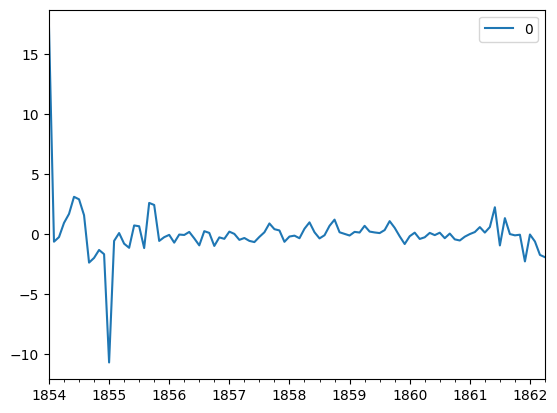

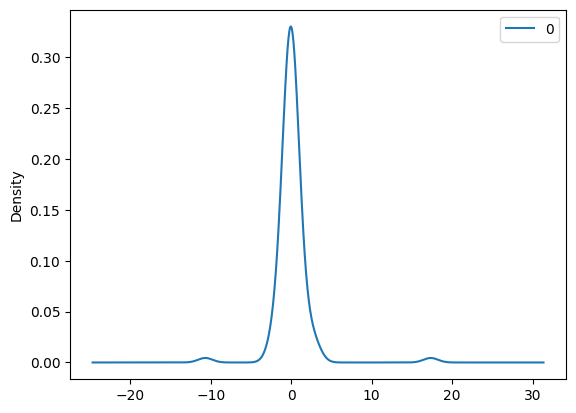

                0
count  100.000000
mean     0.084453
std      2.256246
min    -10.684026
25%     -0.428358
50%     -0.023543
75%      0.279378
max     17.333422


In [281]:
# plot residual errors
residuals = pd.DataFrame(results.resid[0:100])
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

###  Avaliação do modelo

Será realizada uma **walk-forward validation** que é muito boa para usar em projetos próprios de forecasting de séries temporais.

Primeiro, o modelo é treinado com o dataset de treino. Então, é realizada a predição no próximo passo em que a predição é avaliada em contraste com o valor conhecido. O dataset de treino é expandido para incluir o novo valor conhecido e o processo é repetido. 

Na prática o modelo SARIMAX é re-treinado em cada iteração do loop assim que novos pontos do histórico ficam disponíveis.

Re-treinar o modelo a cada iteração torna a predição mais robusta, entretanto, aumenta o custo computacional de ter esses vários modelos.


In [282]:
HORIZONTE = 5 #numero de meses à frente para prever
test_shifted = test.copy()

for t in range(1, HORIZONTE):
    test_shifted['sst+'+str(t)] = test_shifted['sst'].shift(-t, freq='MS')
    
test_shifted = test_shifted.dropna(how='any')
test_shifted.tail(5)

,sst,sst+1,sst+2,sst+3,sst+4
2023-02-01,17.399174,17.524534,17.822731,19.385254,23.629042
2023-03-01,17.524534,17.822731,19.385254,23.629042,27.487192
2023-04-01,17.822731,19.385254,23.629042,27.487192,28.331211
2023-05-01,19.385254,23.629042,27.487192,28.331211,27.635229
2023-06-01,23.629042,27.487192,28.331211,27.635229,26.480513


In [283]:
training_window = 96 # meses de janela de treino (8 anos) 

train_ts = train['sst']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):] #da data atual para anterior

#print(history)
#print(train['sst'])
#train_ts.head()

In [284]:
%%time
predictions = list()
for t in range(test_ts.shape[0]):
    #https://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZONTE)
    predictions.append(yhat)
    observation = list(test_ts.iloc[t])

    # move the training window
    history.append(observation[0])
    history.pop(0)
    
    print(t+1, '. Predicting time step: ', test_ts.index[t])
    print(t+1, ': predicted =', yhat)
    print(t+1, ': expected  =', observation)
    print('----------')


1 . Predicting time step:  1989-11-01 00:00:00
1 : predicted = [20.90419071 18.39347171 16.74948135 16.0007336  15.85668874]
1 : expected  = [21.29566192626953, 19.29193878173828, 17.54727554321289, 16.955896377563477, 16.877939224243164]
----------
2 . Predicting time step:  1989-12-01 00:00:00
2 : predicted = [18.64577265 16.92722356 16.12725068 15.94826588 16.81966334]
2 : expected  = [19.29193878173828, 17.54727554321289, 16.955896377563477, 16.877939224243164, 17.275392532348633]
----------
3 . Predicting time step:  1990-01-01 00:00:00
3 : predicted = [17.31143144 16.38360515 16.12356342 16.94390102 18.87417082]
3 : expected  = [17.54727554321289, 16.955896377563477, 16.877939224243164, 17.275392532348633, 19.326475143432617]
----------
4 . Predicting time step:  1990-02-01 00:00:00
4 : predicted = [16.57506079 16.26506027 17.05255142 18.96110256 22.12050912]
4 : expected  = [16.955896377563477, 16.877939224243164, 17.275392532348633, 19.326475143432617, 22.257177352905273]
-----

34 . Predicting time step:  1992-08-01 00:00:00
34 : predicted = [26.4083878  25.92023857 24.15491052 21.50069344 18.85736633]
34 : expected  = [27.20977210998535, 26.321744918823242, 24.508630752563477, 21.926542282104492, 19.06629180908203]
----------
35 . Predicting time step:  1992-09-01 00:00:00
35 : predicted = [26.68125004 24.87267975 22.19111609 19.52944202 17.65163797]
35 : expected  = [26.321744918823242, 24.508630752563477, 21.926542282104492, 19.06629180908203, 16.940664291381836]
----------
36 . Predicting time step:  1992-10-01 00:00:00
36 : predicted = [24.35330898 21.65786816 18.98990356 17.10039698 16.23446533]
36 : expected  = [24.508630752563477, 21.926542282104492, 19.06629180908203, 16.940664291381836, 16.115524291992188]
----------
37 . Predicting time step:  1992-11-01 00:00:00
37 : predicted = [21.69384515 19.00652113 17.09567455 16.21309822 16.0684445 ]
37 : expected  = [21.926542282104492, 19.06629180908203, 16.940664291381836, 16.115524291992188, 15.834847450

67 . Predicting time step:  1995-05-01 00:00:00
67 : predicted = [18.81145799 21.94276046 25.2334699  27.05341463 26.57510042]
67 : expected  = [18.75275230407715, 22.223173141479492, 25.86536979675293, 27.490026473999023, 25.88593864440918]
----------
68 . Predicting time step:  1995-06-01 00:00:00
68 : predicted = [21.87371553 25.10128793 26.99906083 26.53286925 24.66581292]
68 : expected  = [22.223173141479492, 25.86536979675293, 27.490026473999023, 25.88593864440918, 24.004831314086914]
----------
69 . Predicting time step:  1995-07-01 00:00:00
69 : predicted = [25.3274492  27.12217593 26.61718792 24.72183078 21.96435167]
69 : expected  = [25.86536979675293, 27.490026473999023, 25.88593864440918, 24.004831314086914, 21.39145278930664]
----------
70 . Predicting time step:  1995-08-01 00:00:00
70 : predicted = [27.48052563 26.87118159 24.90897101 22.12515993 19.28804577]
70 : expected  = [27.490026473999023, 25.88593864440918, 24.004831314086914, 21.39145278930664, 18.84257698059082

100 . Predicting time step:  1998-02-01 00:00:00
100 : predicted = [16.63082556 16.40020436 16.86340394 19.11546681 22.31275024]
100 : expected  = [16.803787231445312, 16.366823196411133, 17.0739688873291, 18.906967163085938, 22.674564361572266]
----------
101 . Predicting time step:  1998-03-01 00:00:00
101 : predicted = [16.51296071 16.93139122 19.18058862 22.37716157 25.08012415]
101 : expected  = [16.366823196411133, 17.0739688873291, 18.906967163085938, 22.674564361572266, 25.616737365722656]
----------
102 . Predicting time step:  1998-04-01 00:00:00
102 : predicted = [16.86939473 19.16834374 22.38313556 25.08600696 27.05534271]
102 : expected  = [17.0739688873291, 18.906967163085938, 22.674564361572266, 25.616737365722656, 27.41378402709961]
----------
103 . Predicting time step:  1998-05-01 00:00:00
103 : predicted = [19.28032187 22.42974549 25.14508959 27.10285638 26.30867977]
103 : expected  = [18.906967163085938, 22.674564361572266, 25.616737365722656, 27.41378402709961, 25.

132 . Predicting time step:  2000-10-01 00:00:00
132 : predicted = [24.47400089 21.8779696  19.10356519 17.35733474 16.57242987]
132 : expected  = [24.3035831451416, 22.210905075073242, 19.696256637573242, 17.51232147216797, 16.866092681884766]
----------
133 . Predicting time step:  2000-11-01 00:00:00
133 : predicted = [21.77336855 19.04277151 17.32131846 16.54927203 16.44666073]
133 : expected  = [22.210905075073242, 19.696256637573242, 17.51232147216797, 16.866092681884766, 17.2364559173584]
----------
134 . Predicting time step:  2000-12-01 00:00:00
134 : predicted = [19.31233842 17.4871004  16.66029236 16.52858981 17.14720194]
134 : expected  = [19.696256637573242, 17.51232147216797, 16.866092681884766, 17.2364559173584, 17.608829498291016]
----------
135 . Predicting time step:  2001-01-01 00:00:00
135 : predicted = [17.76748295 16.85958515 16.6818911  17.25767458 19.57732823]
135 : expected  = [17.51232147216797, 16.866092681884766, 17.2364559173584, 17.608829498291016, 19.4907

164 . Predicting time step:  2003-06-01 00:00:00
164 : predicted = [23.18735666 25.81147141 27.50946316 26.58389716 24.74044929]
164 : expected  = [23.88766098022461, 27.30510711669922, 28.692712783813477, 26.72648811340332, 25.034839630126953]
----------
165 . Predicting time step:  2003-07-01 00:00:00
165 : predicted = [26.17899134 27.75219045 26.73811544 24.8423934  22.28263138]
165 : expected  = [27.30510711669922, 28.692712783813477, 26.72648811340332, 25.034839630126953, 22.24296760559082]
----------
166 . Predicting time step:  2003-08-01 00:00:00
166 : predicted = [28.34468983 27.18737905 25.37042928 22.64388881 19.71311955]
166 : expected  = [28.692712783813477, 26.72648811340332, 25.034839630126953, 22.24296760559082, 19.310787200927734]
----------
167 . Predicting time step:  2003-09-01 00:00:00
167 : predicted = [27.46373457 25.56097872 22.79770832 19.83991364 17.79400503]
167 : expected  = [26.72648811340332, 25.034839630126953, 22.24296760559082, 19.310787200927734, 17.28

196 . Predicting time step:  2006-02-01 00:00:00
196 : predicted = [16.26433023 16.38715148 17.04165665 19.32719264 22.73398042]
196 : expected  = [16.3481502532959, 16.411632537841797, 17.294376373291016, 20.209630966186523, 23.06241226196289]
----------
197 . Predicting time step:  2006-03-01 00:00:00
197 : predicted = [16.47465975 17.11121456 19.38539792 22.7842292  25.76102735]
197 : expected  = [16.411632537841797, 17.294376373291016, 20.209630966186523, 23.06241226196289, 27.154958724975586]
----------
198 . Predicting time step:  2006-04-01 00:00:00
198 : predicted = [17.07183998 19.36010526 22.76714395 25.7488019  27.3912852 ]
198 : expected  = [17.294376373291016, 20.209630966186523, 23.06241226196289, 27.154958724975586, 27.586345672607422]
----------
199 . Predicting time step:  2006-05-01 00:00:00
199 : predicted = [19.53310261 22.88901815 25.83962456 27.45637117 26.51195283]
199 : expected  = [20.209630966186523, 23.06241226196289, 27.154958724975586, 27.586345672607422, 2

228 . Predicting time step:  2008-10-01 00:00:00
228 : predicted = [25.357222   22.61975544 19.68390461 17.60725109 16.72057954]
228 : expected  = [24.499753952026367, 22.270851135253906, 19.48225975036621, 17.470727920532227, 16.58864974975586]
----------
229 . Predicting time step:  2008-11-01 00:00:00
229 : predicted = [21.93163288 19.17658382 17.25648999 16.44685903 16.51263431]
229 : expected  = [22.270851135253906, 19.48225975036621, 17.470727920532227, 16.58864974975586, 16.116619110107422]
----------
230 . Predicting time step:  2008-12-01 00:00:00
230 : predicted = [19.38091543 17.38297501 16.53068948 16.56899638 17.27799628]
230 : expected  = [19.48225975036621, 17.470727920532227, 16.58864974975586, 16.116619110107422, 16.98177719116211]
----------
231 . Predicting time step:  2009-01-01 00:00:00
231 : predicted = [17.48084846 16.60575882 16.62929112 17.32944604 19.66595867]
231 : expected  = [17.470727920532227, 16.58864974975586, 16.116619110107422, 16.98177719116211, 19.4

260 . Predicting time step:  2011-06-01 00:00:00
260 : predicted = [22.70513801 26.11830603 27.34944785 26.67319199 24.78263786]
260 : expected  = [22.35022735595703, 26.084733963012695, 27.256301879882812, 27.416872024536133, 24.516881942749023]
----------
261 . Predicting time step:  2011-07-01 00:00:00
261 : predicted = [25.95049557 27.24543749 26.60407019 24.74955666 22.13318693]
261 : expected  = [26.084733963012695, 27.256301879882812, 27.416872024536133, 24.516881942749023, 21.970094680786133]
----------
262 . Predicting time step:  2011-08-01 00:00:00
262 : predicted = [27.38983454 26.71488082 24.84604057 22.220689   19.48032071]
262 : expected  = [27.256301879882812, 27.416872024536133, 24.516881942749023, 21.970094680786133, 19.875221252441406]
----------
263 . Predicting time step:  2011-09-01 00:00:00
263 : predicted = [26.79382033 24.93966369 22.32196729 19.58628468 17.64841155]
263 : expected  = [27.416872024536133, 24.516881942749023, 21.970094680786133, 19.8752212524414

292 . Predicting time step:  2014-02-01 00:00:00
292 : predicted = [16.85548519 16.83360926 17.71464551 19.91876968 23.21340149]
292 : expected  = [17.06609344482422, 16.775867462158203, 17.760601043701172, 19.53337860107422, 23.331174850463867]
----------
293 . Predicting time step:  2014-03-01 00:00:00
293 : predicted = [16.92754405 17.77099028 19.95328592 23.24644836 26.6529738 ]
293 : expected  = [16.775867462158203, 17.760601043701172, 19.53337860107422, 23.331174850463867, 25.866958618164062]
----------
294 . Predicting time step:  2014-04-01 00:00:00
294 : predicted = [17.67655598 19.89460283 23.19728022 26.61265991 27.82448755]
294 : expected  = [17.760601043701172, 19.53337860107422, 23.331174850463867, 25.866958618164062, 27.572227478027344]
----------
295 . Predicting time step:  2014-05-01 00:00:00
295 : predicted = [19.8971481  23.17564231 26.58954604 27.80683052 27.22055299]
295 : expected  = [19.53337860107422, 23.331174850463867, 25.866958618164062, 27.572227478027344, 

324 . Predicting time step:  2016-10-01 00:00:00
324 : predicted = [25.27293151 22.7732385  20.13014607 18.04393442 17.01536584]
324 : expected  = [25.702587127685547, 23.08513069152832, 20.26616668701172, 17.857255935668945, 16.695432662963867]
----------
325 . Predicting time step:  2016-11-01 00:00:00
325 : predicted = [22.95868537 20.22245008 18.08544683 17.03184285 16.85025732]
325 : expected  = [23.08513069152832, 20.26616668701172, 17.857255935668945, 16.695432662963867, 17.02316665649414]
----------
326 . Predicting time step:  2016-12-01 00:00:00
326 : predicted = [20.28363051 18.11601077 17.04725493 16.85802028 17.70063946]
326 : expected  = [20.26616668701172, 17.857255935668945, 16.695432662963867, 17.02316665649414, 17.859270095825195]
----------
327 . Predicting time step:  2017-01-01 00:00:00
327 : predicted = [18.09364369 17.0301509  16.84351588 17.68718629 20.05097135]
327 : expected  = [17.857255935668945, 16.695432662963867, 17.02316665649414, 17.859270095825195, 19.

356 . Predicting time step:  2019-06-01 00:00:00
356 : predicted = [22.64906865 25.82572456 27.48367898 27.06649492 25.15935246]
356 : expected  = [23.054079055786133, 27.156497955322266, 28.38364028930664, 27.7181453704834, 25.84833526611328]
----------
357 . Predicting time step:  2019-07-01 00:00:00
357 : predicted = [26.20613168 27.81068484 27.33997255 25.38505574 22.67126717]
357 : expected  = [27.156497955322266, 28.38364028930664, 27.7181453704834, 25.84833526611328, 23.12702751159668]
----------
358 . Predicting time step:  2019-08-01 00:00:00
358 : predicted = [28.4604568  27.78111605 25.70389163 22.90947462 20.05703468]
358 : expected  = [28.38364028930664, 27.7181453704834, 25.84833526611328, 23.12702751159668, 20.15348243713379]
----------
359 . Predicting time step:  2019-09-01 00:00:00
359 : predicted = [27.68372378 25.6047707  22.83202694 19.99307591 17.97118437]
359 : expected  = [27.7181453704834, 25.84833526611328, 23.12702751159668, 20.15348243713379, 18.019712448120

388 . Predicting time step:  2022-02-01 00:00:00
388 : predicted = [16.85728578 16.80772053 17.57483816 19.83201706 23.34982687]
388 : expected  = [16.64837646484375, 16.26039695739746, 17.130821228027344, 19.809188842773438, 24.038345336914062]
----------
389 . Predicting time step:  2022-03-01 00:00:00
389 : predicted = [16.66864431 17.48315071 19.76599569 23.30675913 26.66369559]
389 : expected  = [16.26039695739746, 17.130821228027344, 19.809188842773438, 24.038345336914062, 27.579591751098633]
----------
390 . Predicting time step:  2022-04-01 00:00:00
390 : predicted = [16.93894311 19.20448611 22.6477223  26.02219398 27.69982289]
390 : expected  = [17.130821228027344, 19.809188842773438, 24.038345336914062, 27.579591751098633, 29.1095027923584]
----------
391 . Predicting time step:  2022-05-01 00:00:00
391 : predicted = [19.39004501 22.83952462 26.20544887 27.87588728 27.42750371]
391 : expected  = [19.809188842773438, 24.038345336914062, 27.579591751098633, 29.1095027923584, 28

In [285]:
eval_df = pd.DataFrame(predictions, columns=['sst+'+str(t) for t in range(1, HORIZONTE+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZONTE+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['atual'] = np.array(np.transpose(test_ts)).ravel()
eval_df.head(1250)

,timestamp,h,prediction,atual
0,1989-11-01,sst+1,20.904191,21.295662
1,1989-12-01,sst+1,18.645773,19.291939
2,1990-01-01,sst+1,17.311431,17.547276
3,1990-02-01,sst+1,16.575061,16.955896
4,1990-03-01,sst+1,16.551414,16.877939
...,...,...,...,...
1245,1992-08-01,sst+4,21.500693,21.926542
1246,1992-09-01,sst+4,19.529442,19.066292
1247,1992-10-01,sst+4,17.100397,16.940664
1248,1992-11-01,sst+4,16.213098,16.115524


#### Computando o MAPE: Mean Absolute Percentage Error sobre todas as predições

O erro percentual absoluto médio ([MAPE](https://docs.oracle.com/cloud/help/pt_BR/pbcs_common/PFUSU/insights_metrics_MAPE.htm#PFUSU-GUID-C33B0F01-83E9-468B-B96C-413A12882334)) é uma medida de erro relativo que usa valores absolutos para impedir que os erros positivos e negativos cancelem uns aos outros e usa erros relativos para permitir que você compare a precisão da previsão entre métodos de série temporais.

$MAPE = \frac{1}{n} \sum_{t=1}^{n} |\frac{A_t - F_t}{A_t}|$ $->$ MAPE = Média de (abs((Atual - Forecast)/(Atual))



In [286]:
if(HORIZONTE > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['atual']).abs() / eval_df['atual']
    print(eval_df.groupby('h')['APE'].mean())

h
sst+1    0.014785
sst+2    0.018264
sst+3    0.019068
sst+4    0.019225
sst+5    0.019088
Name: APE, dtype: float64


In [287]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 'sst+1']['prediction'], eval_df[eval_df['h'] == 'sst+1']['atual']))*100, '%')

One step forecast MAPE:  1.478549318116759 %


In [288]:
print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['atual'])*100, '%')

Multi-step forecast MAPE:  1.8086200333690259 %


### Plotando as predições Versus valor atual para os cinco primeiros meses (t+1,...,t+5)

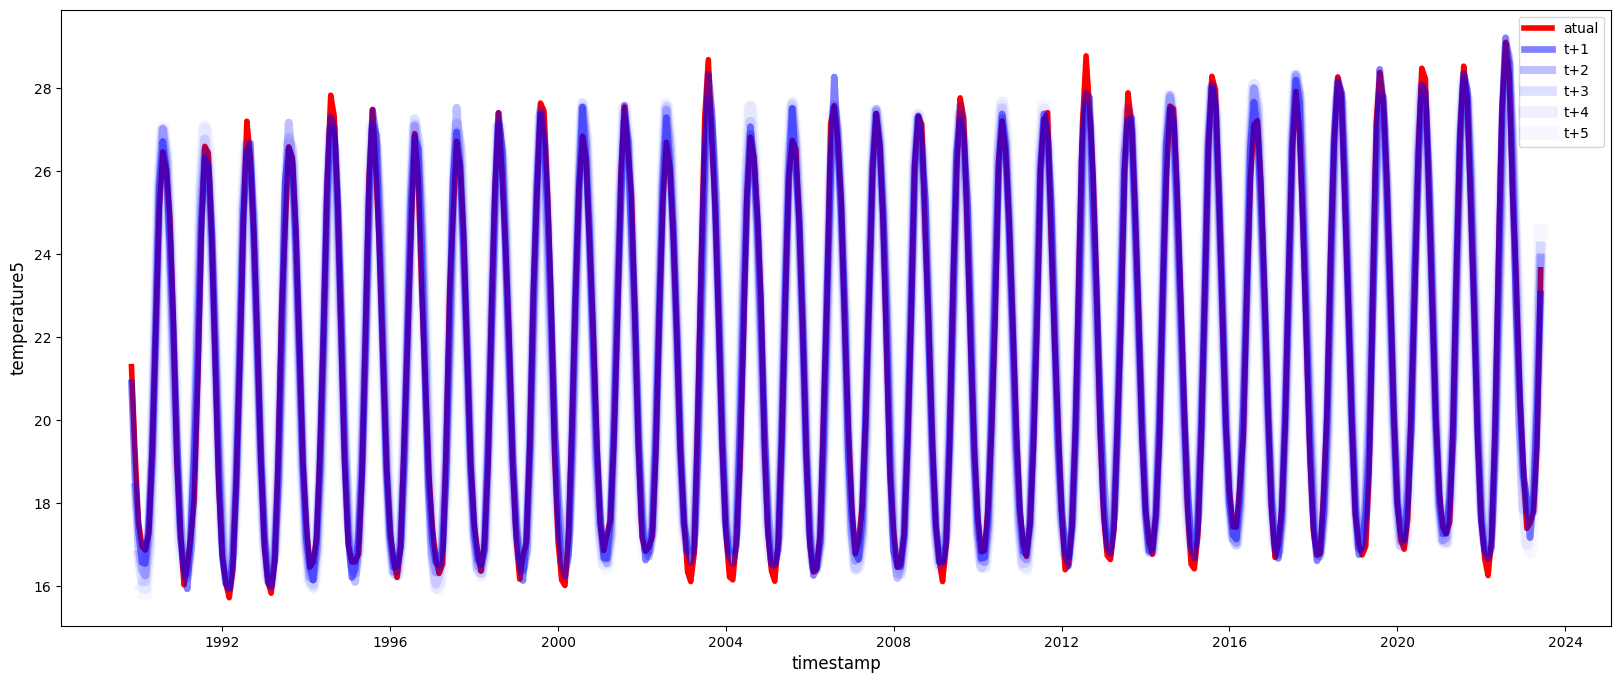

In [289]:
## Plotting multi step forecast
plot_df = eval_df[(eval_df.h=='sst+1')][['timestamp', 'atual']]
for t in range(1, HORIZONTE+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.h=='sst+'+str(t))]['prediction'].values

plot_df.head()
fig = plt.figure(figsize=(20, 8))
plt.plot(plot_df['timestamp'], plot_df['atual'], color='red', linewidth=4.0, label='atual')

for t in range(1, HORIZONTE+1):
    x = plot_df['timestamp'][(t-1):]
    y = plot_df['t+'+str(t)][0:len(x)]
    plt.plot(x, y, color='blue', linewidth=4*math.pow(1.2,t), alpha=math.pow(0.5,t), label='t+'+str(t))

plt.legend()
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('temperature'+str(t), fontsize=12)
plt.show()

### Algumas informações sobre o modelo treinado para SST

In [290]:
print(model_fit.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3362      1.311     -0.256      0.798      -2.905       2.233
ma.L1          0.4194      1.276      0.329      0.742      -2.081       2.920
ar.S.L12      -0.2382      0.182     -1.312      0.190      -0.594       0.118
ma.S.L12      -0.5942      0.183     -3.241      0.001      -0.954      -0.235
sigma2         0.1655      0.031      5.373      0.000       0.105       0.226


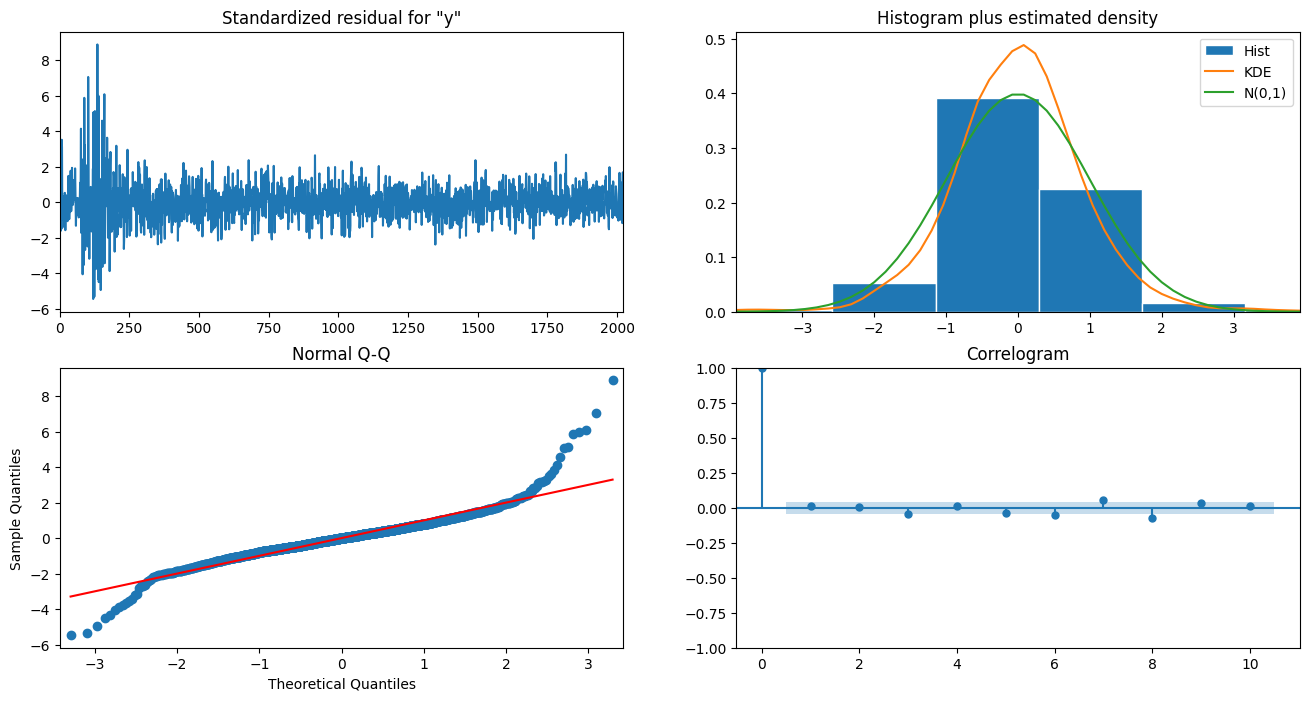

In [40]:
model_fit.plot_diagnostics(figsize=(16, 8))
plt.show()

#### Referências

Este projeto é uma adaptação das seguintes referências:

https://github.com/microsoft/ML-For-Beginners/blob/main/7-TimeSeries/2-ARIMA/README.md

https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/

https://www.kaggle.com/code/ishanharshvardhan/time-series-analysis-and-forecasting-using-arima

